# Creación de un ejemplo adversarial

In [4]:

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

#load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#preprocess data
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#compile CNN network for MNIST classification 
inputs = Input(shape=(28,28,1))
net = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(inputs)
net = Conv2D(64, kernel_size=(3, 3),
                 activation='relu')(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.25)(net)
net = Flatten()(net)
net = Dense(128, activation='relu')(net)
net = Dropout(0.5)(net)
outputs = Dense(10, activation='softmax')(net)

mnist_model = Model(inputs=inputs, outputs=outputs, name='classification_model')
mnist_model.compile(optimizer='nadam', loss='categorical_crossentropy',metrics=[categorical_accuracy])

#train MNIST classifer
earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=0, mode='auto',
                          baseline=None, restore_best_weights=True)

#mnist_model.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, validation_data=(x_test, y_test),
#               callbacks=[earlyStop])
mnist_model.fit(x_train, y_train, batch_size=128, epochs=3, verbose=2, validation_data=(x_test, y_test))

print(mnist_model.evaluate(x_train, y_train))
print(mnist_model.evaluate(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
 - 40s - loss: 0.1986 - categorical_accuracy: 0.9388 - val_loss: 0.0495 - val_categorical_accuracy: 0.9835
Epoch 2/3
 - 39s - loss: 0.0756 - categorical_accuracy: 0.9772 - val_loss: 0.0372 - val_categorical_accuracy: 0.9873
Epoch 3/3
 - 51s - loss: 0.0561 - categorical_accuracy: 0.9830 - val_loss: 0.0332 - val_categorical_accuracy: 0.9891
60000/60000 [==============================] - 18s 306us/step
[0.01913473764181981, 0.9941499829292297]
10000/10000 [==============================] - 3s 273us/step
[0.03318603273532863, 0.9890999794006348]


Eligamos una imagen para crear ejemplo adversarial

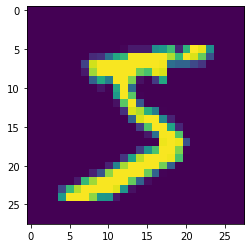

In [5]:
#select image to create an adversarial example from
img = x_train[0:1]
plt.imshow(img.reshape((28,28)),vmin=0., vmax=1.)
plt.show()

Veamos qué clasificacion da el modelo

In [6]:
#varify accurate classificaiton
prediction = mnist_model.predict(img)[0]
print(prediction)


[1.7737483e-11 6.2608922e-09 8.9847067e-11 3.6302149e-02 5.0390000e-12
 9.6368796e-01 3.2505997e-07 7.6546360e-09 1.2309062e-06 8.2603947e-06]


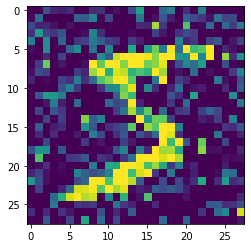

[2.1083179e-06 8.7270295e-05 2.7041782e-05 3.9616412e-01 1.4128898e-06
 5.9841907e-01 4.0781495e-04 2.2897200e-04 2.1130473e-03 2.5491668e-03]


In [7]:
#applying random noise does not fool the classifier
quantized_noise = np.round(np.random.normal(loc=0.0, scale=0.3, size=img.shape) * 255.) / 255.
noisy_img = np.clip(img + quantized_noise, 0., 1.)
plt.imshow(noisy_img.reshape((28,28)),vmin=0., vmax=1.)
plt.show()
noisy_prediction = mnist_model.predict(noisy_img)[0]
print(noisy_prediction)

In [11]:

#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})


#function for generating an adversarial example given a base image, adversarial class target, classifier, and regularization type
def generate_adversary(img,target,model,regularization,loss_function):
    
    #input for base image
    image = Input(shape=(28,28,1),name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='unity')
    
    #layer for learning adversarial noise to apply to image
    noise = Dense(28*28,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape((28,28,1),name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    net = Activation('clip',name='clip_values')(net)
    
    #feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False
    
    adversarial_model.compile(optimizer='nadam', loss=loss_function, metrics=[categorical_accuracy])
        
    #target adversarial classification
    target_vector = np.zeros(10)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                 mode='auto', period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':img,'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=100,verbose=1)
                         #callbacks=[checkpoint])
    #restore best weights
    adversarial_model.load_weights('./adversarial_weights.h5')
    
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((28,28)) * 255.) / 255.
    
    #add trained weights to original image and clip values to produce adversarial image
    adversarial_img = np.clip(img.reshape((28,28)) + quantized_weights, 0., 1.)
    
    #display adversarial image
    plt.imshow(adversarial_img,vmin=0., vmax=1.)
    plt.show()
    #classify adversarial image
    adversarial_prediction = mnist_model.predict(adversarial_img.reshape((1,28,28,1)))
    print(adversarial_prediction)
    
    return adversarial_img

generate_adversary(img,5,mnist_model,l1(0.01),'negative_categorical_crossentropy')
generate_adversary(img,5,mnist_model,l2(0.01),'negative_categorical_crossentropy')
generate_adversary(img,5,mnist_model,l1_l2(l1=0.01,l2=0.01),'negative_categorical_crossentropy')

generate_adversary(img,9,mnist_model,l1(0.01),'categorical_crossentropy')
generate_adversary(img,9,mnist_model,l2(0.01),'categorical_crossentropy')
generate_adversary(img,9,mnist_model,l1_l2(l1=0.01,l2=0.01),'categorical_crossentropy')


Epoch 1/100
1/1 [==============================] - 0s 132ms/step - loss: 0.3112 - categorical_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: -0.6810 - categorical_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2750 - categorical_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 0.2528 - categorical_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2203 - categorical_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: -0.2093 - categorical_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.1604 - categorical_accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: -0.7124 - categorical_accuracy: 0.0000e+00
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: -0.0707 - categorical_accuracy: 1.0000
Epoch

Epoch 74/100
1/1 [==============================] - 0s 4ms/step - loss: -5.7292 - categorical_accuracy: 0.0000e+00
Epoch 75/100
1/1 [==============================] - 0s 4ms/step - loss: -3.3240 - categorical_accuracy: 0.0000e+00
Epoch 76/100
1/1 [==============================] - 0s 3ms/step - loss: -10.8695 - categorical_accuracy: 0.0000e+00
Epoch 77/100
1/1 [==============================] - 0s 3ms/step - loss: -7.9935 - categorical_accuracy: 0.0000e+00
Epoch 78/100
1/1 [==============================] - 0s 4ms/step - loss: -15.6881 - categorical_accuracy: 0.0000e+00
Epoch 79/100
1/1 [==============================] - 0s 4ms/step - loss: -12.5343 - categorical_accuracy: 0.0000e+00
Epoch 80/100
1/1 [==============================] - 0s 4ms/step - loss: -16.6466 - categorical_accuracy: 0.0000e+00
Epoch 81/100
1/1 [==============================] - 0s 3ms/step - loss: -17.2384 - categorical_accuracy: 0.0000e+00
Epoch 82/100
1/1 [==============================] - 0s 3ms/step - loss: -15

OSError: Unable to open file (unable to open file: name = './adversarial_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)